# Web Scraper for Systematic Reviews

In [1]:
import os

temp_folder = os.getenv("temp") + '\\SistRev\\'
os.makedirs(temp_folder, exist_ok=True)

## Keywords to search

In [2]:
search = input("What are we researching today? ")

## Metadata Scraper

In [3]:
from metadataScraper import metadataScraper

files = []

scraper = metadataScraper(download_path=temp_folder)

scraped = scraper.scrape(search)    # returns a list if more than 1000 results found

for file in scraped:
    files.append(file)
    
scraper.quit_driver()
    

Running headless
External IP is 193.136.62.5, which belongs to the range assigned to IPP (193.136.56.0/21)
We are on Traffic Sign Recognition (All Fields) – 1,950 – Web of Science Core Collection
Number of articles:  1950


## Data Cleaner

In [4]:
from datacleaner import DataCleaner

cleaner = DataCleaner()

# This will be handled by metadata scraper 
data_files_path = ['testdata/no-title.ris', 'testdata/artf-intl-wos.ris']

for file in files:
    print(file)
    cleaner.add_file(file)
    
print('Added all files')
print(f'Total number of articles imported: {cleaner.count_in_entries()}')

C:\Users\rpinh\AppData\Local\Temp\SistRev\/traffic_sign_recognition_1_1000.ris
C:\Users\rpinh\AppData\Local\Temp\SistRev\/traffic_sign_recognition_1001_2000.ris
Added all files
Total number of articles imported: 1950


In [5]:
n_dup, n_no_title, n_no_abst, n_no_doi = cleaner.clean_entries()
clean = cleaner.count_out_entries()

print(f'Number of duplicated entries: {n_dup}')
print(f'Number of entries without title: {n_no_title}')
print(f'Number of entries without abstract: {n_no_abst}')
print(f'Number of entries without doi: {n_no_doi}')
print(f'Number of entries after cleanup: {clean}')

Number of duplicated entries: 4
Number of entries without title: 0
Number of entries without abstract: 16
Number of entries without doi: 579
Number of entries after cleanup: 1351


<Axes: title={'center': 'Data Split after Cleanup'}>

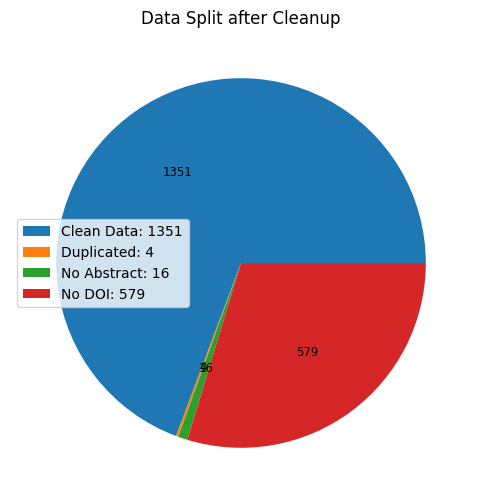

In [6]:
from pandas import Series

datapoints = [clean]
index = [f'Clean Data: {clean}']
if n_dup > 0:
    datapoints.append(n_dup)
    index.append(f'Duplicated: {n_dup}')
    
if n_no_title > 0:
    datapoints.append(n_no_title)
    index.append(f'No Title: {n_no_title}')
    
if n_no_abst > 0:
    datapoints.append(n_no_abst)
    index.append(f'No Abstract: {n_no_abst}')
    
if n_no_doi > 0:
    datapoints.append(n_no_doi)
    index.append(f'No DOI: {n_no_doi}')

ser = Series(datapoints, index=index)

ser.plot(kind='pie', title='Data Split after Cleanup', figsize=(6,6), 
         fontsize='small', autopct=lambda x: '{:.0f}'.format(x * ser.sum() / 100) if x > 0 else '', 
         labels=None, legend=True)

In [7]:
# Output file
cleaner.export_data(path=temp_folder)

## ASREVIEW

In [8]:
import asreview_interfacer as asr

proj = asr.createProject(input("What should we name the project?\nLeave empty for a generated name. "))

proj.add_dataset(f'{temp_folder}/out.ris')

interface = asr.launch_interface()

input("The interface should start in a few seconds.\nWhen finished, export the data to your preferred format an press ENTER/OK kill the web app (You need to close the browser tab manually). ")

interface.kill()